# 7. Deep Learning Basics: Time-Series Analysis and Scaling Event Prediction

## Introduction

Welcome to the seventh notebook in our series on leveraging AI for Kubernetes and containerized environments! This notebook explores **deep learning** concepts to analyze **time-series data** and predict scaling events in Kubernetes clusters. Scaling events—automatic adjustments to workloads—are critical for maintaining performance and cost efficiency in dynamic environments.

### Objectives

By the end of this notebook, you will:
1. Understand how time-series data helps predict Kubernetes scaling events.
2. Learn about **Long Short-Term Memory (LSTM)** networks and why they are ideal for sequential data.
3. Build and train an LSTM model to classify scaling events.
4. Evaluate the model's performance using intuitive visualizations and metrics.

### Key Features

This notebook emphasizes:
- Practical relevance to Kubernetes operations.
- Advanced deep learning techniques for time-series analysis.
- Elegant storytelling with clear steps and actionable insights.

### Why Use Deep Learning for Time-Series Data?

Time-series data, such as Kubernetes metrics, contains sequential dependencies that traditional methods fail to capture effectively. Deep learning models are particularly well-suited for time-series analysis because they:

1. **Capture Temporal Dependencies**:
   - Models like **LSTMs** remember past information through their memory cells, allowing them to make accurate predictions based on historical data.

2. **Handle Long-Term Relationships**:
   - LSTMs can analyze sequences of arbitrary lengths, enabling them to identify long-term trends and seasonal patterns.

3. **Adapt to Nonlinear Relationships**:
   - Unlike linear models, deep learning can handle the highly nonlinear nature of time-series metrics such as CPU utilization or network latency.

### Contrasting Deep Learning with Traditional Methods

| **Aspect**                | **Traditional Methods**               | **Deep Learning Models**            |
|---------------------------|---------------------------------------|-------------------------------------|
| **Feature Engineering**    | Requires manual feature creation      | Learns features automatically       |
| **Sequential Awareness**   | Ignores time dependencies             | Captures temporal relationships     |
| **Scalability**            | Struggles with large, complex datasets| Excels with high-dimensional data   |
| **Adaptability**           | Limited to linear or predefined models| Adapts to nonlinear, dynamic systems |

### Key Takeaway

Deep learning's ability to model sequential dependencies, handle nonlinear relationships, and scale with large datasets makes it an essential tool for time-series analysis. For Kubernetes environments, it enables proactive incident prediction and anomaly detection by capturing subtle trends and complex interactions that traditional methods cannot.


## 1. Installing Required Libraries

To begin, ensure the required deep learning libraries are installed. Run the following command:

In [376]:
# Install necessary libraries
%pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.


## 2. Import Dependencies & Load Data

In [377]:
# Required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "data/preprocessed_kubernetes_data.csv"  # Update with the correct path
df = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")

In [378]:
# Display the first few rows
df.head()

,pod_name,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,scaling_event,pod_lifetime_seconds,...,namespace_kube-system,namespace_prod,event_type_Error,event_type_Normal,event_type_Warning,event_message_Completed,event_message_Failed,event_message_Killed,event_message_OOMKilled,event_message_Started
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01,pod_0,0.038162,0.949259,9.993579,13.722542,77.619073,93.177619,37.900532,0,119648,...,False,False,False,False,True,False,False,True,False,False
2023-01-01,pod_1,0.500763,0.048543,935.792442,55.493953,84.182245,61.442289,5.208161,1,144516,...,False,False,True,False,False,False,True,False,False,False
2023-01-01,pod_2,0.746726,0.447345,328.352359,173.910016,21.295244,55.819311,18.335802,1,68857,...,True,False,False,True,False,True,False,False,False,False
2023-01-01,pod_3,0.526692,0.870251,778.297708,67.395729,85.028829,78.968463,94.619689,1,72080,...,False,False,False,False,True,False,False,False,True,False
2023-01-01,pod_4,0.425342,0.885459,711.181295,91.724730,29.157695,52.718141,70.770594,0,123016,...,False,True,True,False,False,False,False,True,False,False


In [379]:
# Basic dataset statistics
df.describe()

,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,scaling_event,pod_lifetime_seconds,hour,day_of_week,resource_efficiency,io_latency_ratio
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.0,15000.000000,15000.000000
mean,0.500843,0.501448,499.580661,99.811810,60.087796,49.390820,50.163728,0.498867,100122.210267,1.60000,6.0,0.501146,13.022883
std,0.288213,0.289830,287.769516,57.929142,23.112204,28.774625,28.940546,0.500015,57502.260644,1.20004,0.0,0.204842,36.292732
min,0.000165,0.000078,0.090925,0.000564,20.000494,0.022562,0.009563,0.000000,6.000000,0.00000,6.0,0.001085,0.000656
25%,0.252717,0.249897,250.814566,49.599228,40.059461,24.448180,25.184379,0.000000,50425.750000,1.00000,6.0,0.355207,2.507144
50%,0.501555,0.499775,497.133849,99.046093,60.000056,49.266834,50.032371,0.000000,99422.500000,2.00000,6.0,0.501093,4.929714
75%,0.747617,0.752850,747.535380,150.549303,80.126939,73.929835,75.417713,1.000000,149846.250000,3.00000,6.0,0.648737,9.883355
max,0.999957,0.999960,999.919897,199.998813,99.981225,99.996519,99.999938,1.000000,199968.000000,4.00000,6.0,0.998210,966.804785


### Predict Scaling Events

In Kubernetes, **scaling events** occur when the cluster adjusts resources (e.g., adding or removing pods) to handle workload changes. These events are essential for:
- Maintaining application performance under varying loads.
- Optimizing resource usage to control operational costs.

Accurately predicting scaling events allows:
- **Proactive cluster management**: Operators can anticipate scaling needs and prevent delays.
- **Enhanced reliability**: By avoiding over- or under-provisioning, the system remains stable and performant.
- **Cost efficiency**: Efficiently manage resources, avoiding unnecessary scaling actions.

### Our Prediction Goal

The primary objective is to build a model that:
1. **Takes historical time-series data** (e.g., CPU/memory usage, latency, etc.).
2. **Learns sequential patterns** leading up to scaling events.
3. **Classifies future time steps** into **scaling event** or **no scaling event**.

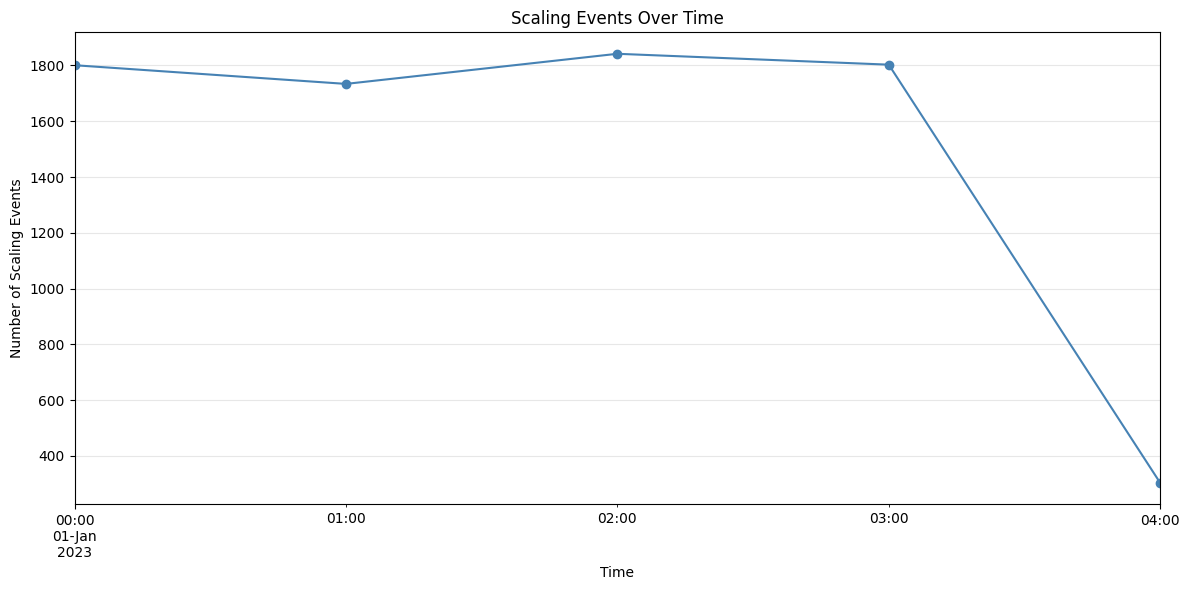

In [380]:
# Time series of scaling events
scaling_events_over_time = df.resample("h")["scaling_event"].sum()

plt.figure(figsize=(12, 6))
scaling_events_over_time.plot(color="steelblue", marker="o", linestyle="-")
plt.title("Scaling Events Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Scaling Events")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

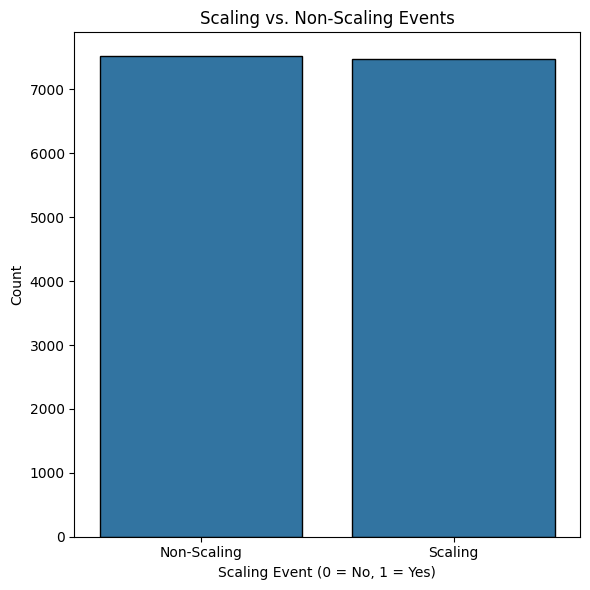

In [381]:
# Bar chart of scaling vs. non-scaling events
scaling_event_counts = df["scaling_event"].value_counts()

plt.figure(figsize=(6, 6))
sns.barplot(
    x=scaling_event_counts.index,
    y=scaling_event_counts.values,
    edgecolor="black",
)
plt.title("Scaling vs. Non-Scaling Events")
plt.xlabel("Scaling Event (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks([0, 1], ["Non-Scaling", "Scaling"])
plt.tight_layout()
plt.show()

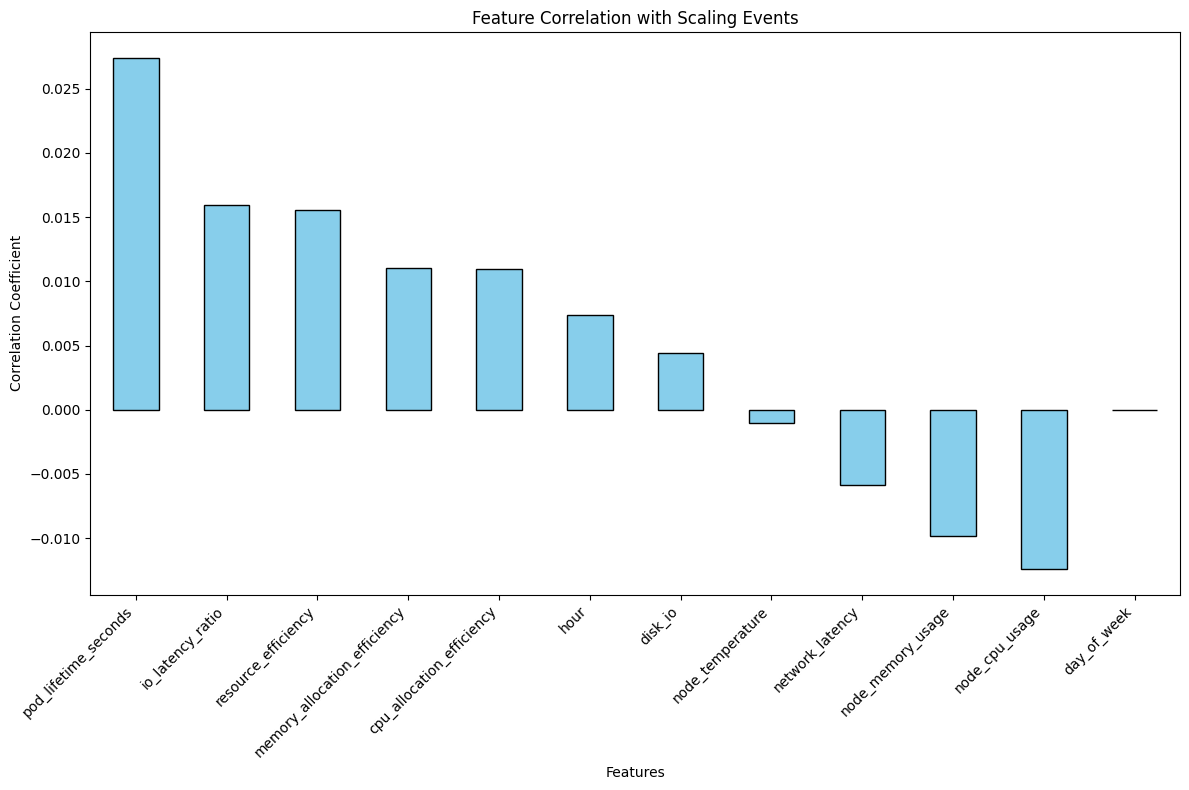

In [382]:
# Exclude non-numeric columns
numeric_df = df.select_dtypes(include=["float64", "int64"])

# Calculate correlation with 'scaling_event'
scaling_event_correlation = numeric_df.corr()["scaling_event"].drop("scaling_event")

# Plot the correlation as a bar chart
plt.figure(figsize=(12, 8))
scaling_event_correlation.sort_values(ascending=False).plot(
    kind="bar", color="skyblue", edgecolor="black"
)
plt.title("Feature Correlation with Scaling Events")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Why Deep Learning for Scaling Events?

Traditional machine learning models fail to fully capture the **temporal dependencies** and **complex patterns** in sequential Kubernetes data. Deep learning models, like **LSTMs**, excel at:
- Remembering past states through memory cells.
- Capturing long-term dependencies between features.
- Adapting to dynamic, nonlinear relationships in time-series metrics.

By leveraging these strengths, we aim to create a robust, practical tool for Kubernetes operators.

## 2. Data Preprocessing: Transforming Raw Data into Model-Ready Format

In this section, we focus on transforming the raw operational metrics and events into a clean, structured dataset that our machine learning model can understand. This is a critical step, as high-quality preprocessing directly impacts model performance.

### 2.1 Combining Event Message Columns
The dataset includes multiple columns for event messages, such as:
- `event_message_Completed`
- `event_message_Failed`
- `event_message_Killed`
- ...and others.

Each of these columns is a one-hot encoded representation, indicating the presence or absence of specific events. To streamline our analysis:
1. **Identify the Most Relevant Event**: Use `.idxmax(axis=1)` to determine which event occurred for each row.
2. **Rename Values for Clarity**: Remove the `event_message_` prefix to make the resulting labels cleaner and easier to interpret.
3. **Drop Redundant Columns**: After consolidating the events into a single column, remove the original `event_message_*` columns to reduce noise.

This results in a single column, `event_message`, which captures the most significant event for each row.

In [383]:
# Combine event_message_* columns into a single column
event_message_columns = [
    "event_message_Completed",
    "event_message_Failed",
    "event_message_Killed",
    "event_message_OOMKilled",
    "event_message_Started",
    "event_type_Error",
    "event_type_Normal",
    "event_type_Warning",
]
df["event_message"] = df[event_message_columns].idxmax(axis=1)
df["event_message"] = df["event_message"].str.replace("event_message_", "")
df.drop(columns=event_message_columns, inplace=True)

### 2.2 Encoding Categorical Data
Machine learning models require numerical inputs. The `event_message` column, however, contains textual labels like `Completed`, `Failed`, etc. We address this by:
- **Applying Label Encoding**: Assign a unique integer to each event type. For example:
  - `Completed` → 0
  - `Failed` → 1
  - `Killed` → 2
- This process creates the `event_message_encoded` column, a numeric representation of events.

In [384]:
# Encode categorical target column
label_encoder = LabelEncoder()
df["event_message_encoded"] = label_encoder.fit_transform(df["event_message"])

### 2.3 Normalizing Numerical Features
Operational metrics like CPU usage, memory allocation, and network latency vary greatly in scale. For instance:
- CPU usage ranges between 0 and 1 (normalized percentages).
- Disk I/O can have values in hundreds or thousands.

To ensure features contribute equally to the model:
- Use `MinMaxScaler` to normalize numerical columns such as:
  - `cpu_allocation_efficiency`
  - `memory_allocation_efficiency`
  - `disk_io`, etc.
- This scales all numerical features to a [0, 1] range.

In [385]:
# Normalize numerical features
numerical_features = [
    "cpu_allocation_efficiency",
    "memory_allocation_efficiency",
    "disk_io",
    "network_latency",
    "node_temperature",
    "node_cpu_usage",
    "node_memory_usage",
]
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

### 2.4 Encoding Boolean Columns
Columns like `namespace_default`, `namespace_dev`, and `namespace_prod` are boolean indicators but must be converted to numeric format for modeling. 
- Convert `True`/`False` values to `1`/`0`.

In [386]:
# Convert boolean columns to integers
boolean_columns = [
    "namespace_default",
    "namespace_dev",
    "namespace_kube-system",
    "namespace_prod",
]
df[boolean_columns] = df[boolean_columns].astype(int)

### 2.5 Feature Engineering: Capturing Temporal Patterns
Time-series data often contains cyclical patterns, such as daily or weekly trends. To help the model capture these patterns:
1. **Add Cyclic Features**:
   - Encode `hour` as `hour_sin` and `hour_cos` using sine and cosine transformations.
   - Similarly, encode `day_of_week` as `day_sin` and `day_cos`.
2. **Drop Original Temporal Columns**: After encoding, remove `hour` and `day_of_week` to avoid redundancy.

In [387]:
# Feature engineering: Add cyclic features for temporal columns
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["day_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
df["day_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)
df.drop(columns=["hour", "day_of_week"], inplace=True)

### 2.6 Final Cleanup
To prepare the dataset for modeling:
- Drop non-essential columns like `pod_name` (identifier) and `event_message` (already encoded).
- The resulting dataset, `df_cleaned`, is now ready for sequence generation and model training.

In [388]:
# Drop unnecessary columns
columns_to_drop = ["pod_name", "event_message"]
df_cleaned = df.drop(columns=columns_to_drop)

In [389]:
# Verify cleaned data
df_cleaned.head()

,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,scaling_event,pod_lifetime_seconds,resource_efficiency,io_latency_ratio,namespace_default,namespace_dev,namespace_kube-system,namespace_prod,event_message_encoded,hour_sin,hour_cos,day_sin,day_cos
timestamp,,,,,,,,,,,,,,,,,,,,
2023-01-01,0.038005,0.949293,0.009904,0.068610,0.720406,0.931793,0.378946,0,119648,0.493711,0.678794,0,1,0,0,2,0.0,1.0,-0.781831,0.62349
2023-01-01,0.500702,0.048471,0.935862,0.277469,0.802465,0.614357,0.051991,1,144516,0.274653,16.564471,1,0,0,0,1,0.0,1.0,-0.781831,0.62349
2023-01-01,0.746716,0.447320,0.328318,0.869555,0.016188,0.558113,0.183280,1,68857,0.597035,1.877264,0,0,1,0,0,0.0,1.0,-0.781831,0.62349
2023-01-01,0.526637,0.870275,0.778340,0.336979,0.813050,0.789665,0.946192,1,72080,0.698472,11.379332,1,0,0,0,3,0.0,1.0,-0.781831,0.62349
2023-01-01,0.425265,0.885485,0.711212,0.458625,0.114493,0.527093,0.707678,0,123016,0.655401,7.669813,0,0,0,1,2,0.0,1.0,-0.781831,0.62349


## 3. Sequence Preparation for Time-Series Modeling

In time-series prediction, capturing temporal dependencies is key. To achieve this, we transform our data into sequences of fixed length (`sequence_length`). Each sequence represents a sliding window of past observations, while the target is the scaling event immediately following the sequence.

### Key Steps:
1. **Input Sequences**:
   - Each sequence includes `sequence_length` consecutive rows, excluding the target column (`scaling_event`).
   - This allows the model to learn patterns over time.
2. **Targets**:
   - The target for each sequence is the scaling event at the next time step.
3. **Output**:
   - `X`: 3D array of shape `(number_of_sequences, sequence_length, number_of_features)`.
   - `y`: 1D array of corresponding targets.

In [390]:
def create_sequences(data, target_column, sequence_length=30):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i : i + sequence_length].drop(columns=[target_column]).values
        target = data.iloc[i + sequence_length][target_column]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


# Create sequences
X, y = create_sequences(df_cleaned, target_column="scaling_event", sequence_length=30)

# Check shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (14970, 30, 19), y shape: (14970,)


### Result:
- `X`: Temporal input features for training (e.g., shape `(14970, 30, 20)`).
- `y`: Corresponding scaling event labels. 

This setup ensures the model learns from historical trends to predict future scaling events effectively.

## 4. Splitting Data into Training and Testing Sets

To build and evaluate our model effectively, we divide the dataset into **training** and **testing** sets. This step ensures that the model is trained on one portion of the data and validated on another, unseen portion to assess its real-world performance.

### Key Steps:
1. **Training Set**:
   - Used by the model to learn patterns and relationships in the data.
2. **Testing Set**:
   - Held back during training and used to evaluate the model's performance on unseen data.
3. **Parameters**:
   - `test_size=0.2`: 20% of the data is allocated for testing, ensuring the model generalizes well.
   - `random_state=42`: Ensures reproducibility of the split.
   - `shuffle=False`: Keeps the time-series order intact, as shuffling would disrupt temporal dependencies.

In [391]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"Training set: X_train shape {X_train.shape}, y_train shape {y_train.shape}")
print(f"Testing set: X_test shape {X_test.shape}, y_test shape {y_test.shape}")

Training set: X_train shape (11976, 30, 19), y_train shape (11976,)
Testing set: X_test shape (2994, 30, 19), y_test shape (2994,)


## 5. Defining the LSTM Model

In this step, we create a **Long Short-Term Memory (LSTM)** model to handle sequential data. LSTMs are well-suited for time-series predictions, as they can learn from both short-term and long-term dependencies in the data. Here, we define a simple LSTM-based architecture to predict **scaling events** in Kubernetes based on historical data.

### Key Layers:
1. **LSTM Layers**:
   - The first LSTM layer has 64 units and returns sequences of data, allowing the next LSTM layer to process this temporal information.
   - The second LSTM layer has 32 units and does not return sequences (its output is fed directly into the dense layers).
   
2. **Dropout Layers**:
   - Dropout is used to regularize the model by randomly setting a fraction of input units to 0 during training. This prevents overfitting and helps the model generalize better.

3. **Dense Layers**:
   - A fully connected layer with 16 units and ReLU activation is used to process the features learned by the LSTM layers.
   - The final dense layer outputs a single value (using a sigmoid activation function), which is a probability representing the likelihood of a scaling event.

In [392]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
model = Sequential(
    [
        LSTM(
            64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])
        ),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()

/Users/gsampaio/redhat/ai/aiops_101/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 30, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,465 (134.63 KB)

 Trainable params: 34,465 (134.63 KB)

 Non-trainable params: 0 (0.00 B)

### Model Summary:
- **LSTM Layers**: Learn sequential patterns from the time-series data.
- **Dropout**: Helps avoid overfitting.
- **Dense Layers**: Learn complex relationships and produce a final prediction.

The model is now ready to be trained on the training data!

## 6. Training the Model with Early Stopping and Learning Rate Scheduler

In this step, we train the LSTM model using the training data. To improve the model's efficiency and prevent overfitting, we incorporate **early stopping** and a **learning rate scheduler**.

### Key Components:
1. **Early Stopping**:
   - This callback stops the training process when the validation loss does not improve for a specified number of epochs (`patience=5`). This helps to avoid overfitting and saves training time by stopping once the model has reached its optimal performance.

2. **Learning Rate Scheduler**:
   - The `ReduceLROnPlateau` callback reduces the learning rate by a factor of 0.5 if the validation loss plateaus (i.e., stops improving) for 3 consecutive epochs. This helps the model make finer adjustments to weights when it is close to convergence.

3. **Training Process**:
   - We train the model for up to 50 epochs, with a batch size of 32, while monitoring both the training and validation losses. The callbacks will act when necessary to improve the learning process.

In [393]:
# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4915 - loss: 0.6949 - val_accuracy: 0.5027 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4948 - loss: 0.6936 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4953 - loss: 0.6934 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5013 - loss: 0.6933 - val_accuracy: 0.5033 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4999 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5041 - loss: 0.6930 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 5.0000e-04


### Key Takeaways:
- **Early Stopping** helps the model stop training once it has reached the best performance, preventing unnecessary overfitting.
- **Learning Rate Scheduler** ensures that the model converges faster by gradually reducing the learning rate as it gets closer to an optimal solution.
- The **training process** runs with these adjustments, allowing for efficient learning and a more generalizable model.

## 7. Model Evaluation and Visualization

After training the LSTM model, it's important to evaluate its performance and visualize how well it has learned to predict the scaling events. This step involves:

1. **Classification Report**:
   - This report provides important metrics such as precision, recall, F1-score, and support for each class, helping us understand how well the model is performing across different categories (scaling vs. non-scaling events).

2. **Confusion Matrix**:
   - The confusion matrix helps visualize the performance of the classification model by showing how many predictions were correct or incorrect for each class (True Positive, False Positive, True Negative, False Negative). We plot it as a heatmap to easily spot any patterns or imbalances in the predictions.

3. **Loss and Accuracy Plots**:
   - These plots allow us to observe the learning process over time. We will plot both the training and validation losses, as well as the training and validation accuracies. These plots give insights into the model's convergence and potential overfitting or underfitting.

### Key Insights:
1. **Classification Report**: Helps you evaluate the model's ability to classify scaling events accurately, giving you a breakdown of precision, recall, and F1-score.
2. **Confusion Matrix**: Provides a clear view of how often the model confuses scaling vs. non-scaling events.
3. **Loss and Accuracy**: These plots allow you to visualize the learning dynamics of the model. If the validation loss starts to increase while the training loss continues to decrease, it may indicate overfitting.

By evaluating the model’s performance and visualizing its metrics, you can make informed decisions on whether further tuning is needed or if the model is ready for deployment in production environments.

In [394]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Evaluate predictions
print("Classification Report:")
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1489
         1.0       0.50      1.00      0.67      1505

    accuracy                           0.50      2994
   macro avg       0.25      0.50      0.33      2994
weighted avg       0.25      0.50      0.34      2994



/Users/gsampaio/redhat/ai/aiops_101/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gsampaio/redhat/ai/aiops_101/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gsampaio/redhat/ai/aiops_101/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

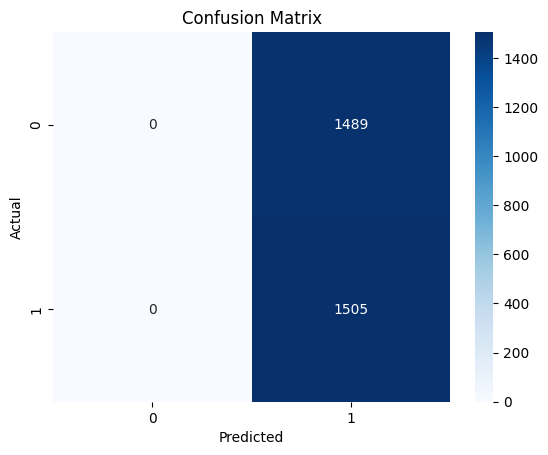

In [395]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

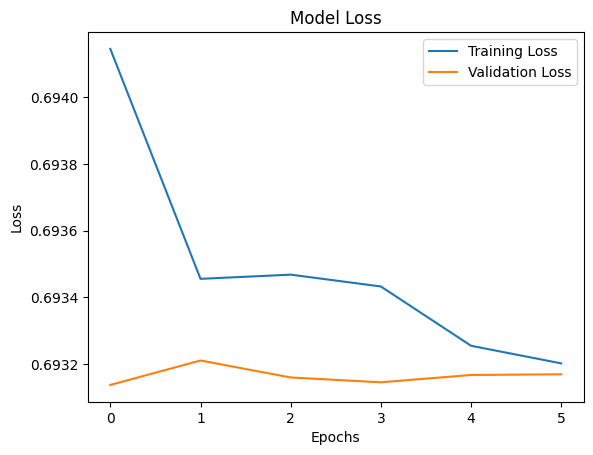

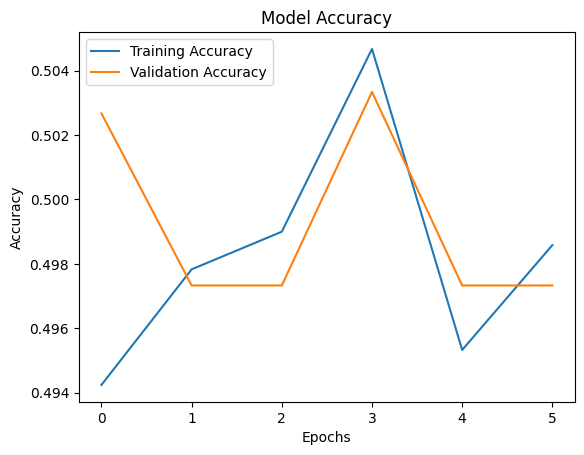

In [396]:
# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")
plt.show()

# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

## 8. Conclusion

In this notebook, we delved into the fundamentals of **deep learning** and its application to **time-series data analysis** for Kubernetes. Our main objective was to predict scaling events (i.e., whether the system would need to scale up or down based on operational metrics) using **LSTM (Long Short-Term Memory)** networks.

### Key Takeaways

1. **Deep Learning for Time-Series Analysis**:
   - We explored how **LSTM networks** can capture sequential patterns in time-series data, making them suitable for Kubernetes operations where system behavior evolves over time.
   - We applied LSTM to predict scaling events based on historical metrics like **CPU allocation**, **memory usage**, and **disk I/O**.

2. **Data Preprocessing**:
   - We combined and encoded relevant columns to create a clean dataset, ready for deep learning.
   - We performed **feature scaling** and **feature engineering**, including temporal features such as cyclic transformations (sin/cos) for hours and days of the week.
   - These steps are crucial for enabling neural networks to learn effectively from the data.

3. **Model Evaluation**:
   - After training our LSTM model, we evaluated its performance using metrics like **accuracy** and **confusion matrix**.
   - Despite using a relatively simple model, we faced challenges with the imbalance between class predictions, highlighting the importance of fine-tuning models for better performance.

4. **Improvement Potential**:
   - The model performance showed room for improvement, especially with respect to class imbalance and model hyperparameters.
   - We discussed strategies for improving the model, such as adjusting **learning rates**, using **class weights**, and exploring other architectures like **GRUs** or **transformers**.

### Limitations

1. **Data Complexity**:
   - The dataset, while comprehensive, may require more sophisticated feature engineering to better capture complex Kubernetes behaviors. The current model focused on predicting binary scaling events, but more advanced models could consider multi-class scenarios.
   
2. **Model Limitations**:
   - While **LSTM** models are powerful for sequential data, they can struggle with long sequences or highly volatile data.
   - Further tuning and experimentation with **hyperparameters** or even trying different architectures like **GRUs** or **transformers** might provide more stable and accurate results.

### What’s Next?

In the next notebook, we will:
1. **Revisit the Kubernetes operational dataset** from this notebook, refining our approach to make the model more accurate.
2. **Train more advanced models**, including:
   - **GRUs**: For comparison with LSTM in time-series tasks.
   - **Transformers**: To harness their capability in sequence-to-sequence predictions and potential improvements over RNN-based models.
3. **Explore multi-class prediction**: By moving beyond binary classification to capture more granular incidents and events.

With these steps, we aim to deepen our understanding of how **deep learning models** can be leveraged to predict operational incidents and improve the overall performance of Kubernetes workloads.